In [18]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import class_weight
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [20]:
base_dir = "Rice Leaf Disease Images"

In [74]:
img_height = 224
img_width = 224
channels = 3
batch_size = 128


In [75]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,  
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

class_names = df.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in df:
    for label in labels.numpy():  
        class_counts[class_names[int(label)]] += 1  

print(class_counts)

Found 6227 files belonging to 4 classes.
{'Bacterialblight': 1584, 'Blast': 1440, 'Brownspot': 1600, 'Tungro': 1603}


In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    validation_split=0.2,
    zoom_range=0.3,
)

In [78]:
train_ds = datagen.flow_from_directory(
  base_dir,
  subset="training",
  target_size=(img_height, img_width),
  batch_size=batch_size,
  seed=123,
  class_mode = "categorical"
  )

Found 4983 images belonging to 4 classes.


In [79]:
val_ds = datagen.flow_from_directory(
  base_dir,
  subset="validation",
  target_size=(img_height, img_width),
  batch_size=batch_size,
  seed=123,
  class_mode = "categorical")

Found 1244 images belonging to 4 classes.


In [80]:
data_dir = base_dir  
class_names = sorted(os.listdir(data_dir))
print(class_names)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


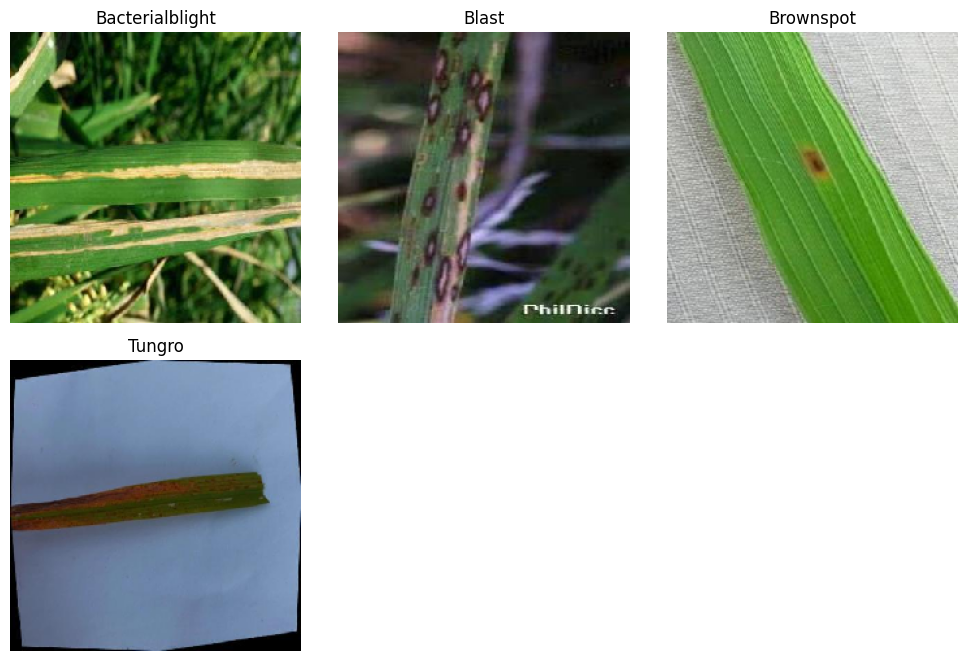

In [81]:
from tensorflow.keras.preprocessing import image
import random
class_names = os.listdir(data_dir)

plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):  
        
        image_files = os.listdir(class_dir)
        
        if image_files:
           
            img_path = os.path.join(class_dir, random.choice(image_files))         
            img = image.load_img(img_path, target_size=(224, 224))
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

plt.tight_layout()
plt.show()

*Model Build*

In [82]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer = "he_uniform", padding = "valid", input_shape=(img_width, img_height, channels)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer = "he_uniform", padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_uniform"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax', kernel_initializer="glorot_uniform")
    
    ])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 23,335,108 (89.02 MB)

 Trainable params: 23,332,612 (89.01 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [83]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [84]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler],
)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.3604 - loss: 1.4213 - val_accuracy: 0.2540 - val_loss: 13.8409 - learning_rate: 1.0000e-04
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5585 - loss: 1.0777 - val_accuracy: 0.2701 - val_loss: 5.2160 - learning_rate: 1.0000e-04
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.6632 - loss: 0.8855 - val_accuracy: 0.4309 - val_loss: 3.8656 - learning_rate: 1.0000e-04
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.7464 - loss: 0.6739 - val_accuracy: 0.5257 - val_loss: 3.8918 - learning_rate: 1.0000e-04
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.7944 - loss: 0.5347 - val_accuracy: 0.6150 - val_loss: 3.2445 - learning_rate: 1.0000e-04
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8314 - loss: 0.4650 - val_accuracy: 0.6037 - val_loss: 3.1314 - learning_rate: 1.0000e-04
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.8338

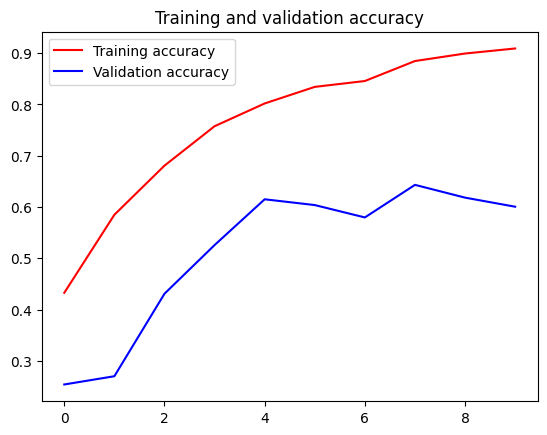

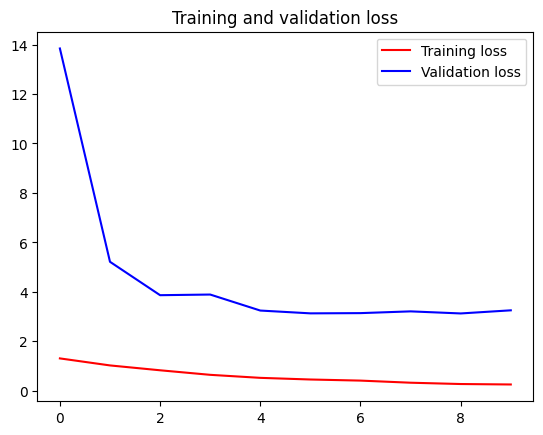

<Figure size 640x480 with 0 Axes>

In [85]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [86]:
model.save('SmartPaddy_25.0_.h5')  

In [87]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


img_path = r'dataset\blight\bacterial_leaf_blight-1-_jpg.rf.bdd90f9f37ff341812e4f16c1b0e3c7f.jpg'


model = load_model(r'SmartPaddy_25.0_.h5')



img = image.load_img(img_path, target_size=(224, 224))


x = image.img_to_array(img)


x = np.expand_dims(x, axis=0)


images = np.vstack([x])
classes = model.predict(images)

class_names = os.listdir(data_dir)


predicted_class = class_names[np.argmax(classes)]  
predicted_prob = np.max(classes)  

print(f"Predicted Class: {predicted_class}")
print(f"Probability: {predicted_prob:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted Class: Blast
Probability: 0.67


*Transfer Learning*

In [100]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [103]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

for layer in base_model.layers[:-10]:
    layer.trainable = False

    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)   
x = BatchNormalization()(x)           
x = Dropout(0.4)(x)                    
x = Dense(256, activation='relu')(x)   
x = BatchNormalization()(x)            
x = Dropout(0.3)(x)                    


prediction = Dense(4, activation='softmax')(x)  


model = Model(inputs=base_model.input, outputs=prediction)


In [104]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [105]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.4536 - loss: 1.5190 - val_accuracy: 0.2765 - val_loss: 6.2330
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.6537 - loss: 0.9488 - val_accuracy: 0.4035 - val_loss: 3.7833
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.6748 - loss: 0.8688 - val_accuracy: 0.4887 - val_loss: 3.2528
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.6902 - loss: 0.8261 - val_accuracy: 0.5064 - val_loss: 2.8998
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.7225 - loss: 0.7514 - val_accuracy: 0.5466 - val_loss: 2.5869
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.7313 - loss: 0.7328 - val_accuracy: 0.5595 - val_loss: 2.2377
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.7377 - loss: 0.7021 - val_accuracy: 0.5619 - val_loss: 2.1853
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.7633 - loss: 0.6486 - val_accuracy: 0.5699 - v

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model.save('SmartPaddy_22.0_.h5')  

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


img_path = r'dataset\brown spot\brownspot_orig_006_png_jpg.rf.e77ce832a9a1b5708638f8115fb917a3.jpg'


model = load_model(r'SmartPaddy_22.0_.h5')



img = image.load_img(img_path, target_size=(224, 224))


x = image.img_to_array(img)


x = np.expand_dims(x, axis=0)


images = np.vstack([x])
classes = model.predict(images)

class_names = os.listdir(data_dir)


predicted_class = class_names[np.argmax(classes)]  
predicted_prob = np.max(classes)  

print(f"Predicted Class: {predicted_class}")
print(f"Probability: {predicted_prob:.2f}")


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)